# Installation of conda and Gmpy2

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge gmpy2

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...
Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - gmpy2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.1.31  |       hbcca054_0         154 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    conda-24.11.3              |  py311h38be061_0         1.1 MB  conda-forge
    gmp-6.3.0                  |       hac33072_2         449 KB  conda-forge
    gmpy2-2.1.5                |  py311h0f6cedb_3         198 KB  conda-forge
    mpc-1.3.1                  |      

# Paillier implementation with Gmpy2 from TP

### Import required packages

In [1]:
from gmpy2 import root, mpfr, cbrt, sqrt, c_div, is_prime, random_state, mpz_urandomb
from gmpy2 import bit_set, next_prime, bit_length, num_digits, mpz_random, gcd
from gmpy2 import invert, powmod, mpz
import time
import random

### Generation of prime numbers


In [3]:
def get_prime(size): # size is the binary size
    seed = random_state(time.time_ns())
    p = mpz_urandomb(seed, size)
    p = p.bit_set(size - 1)
    return next_prime(p)

### Generation of Paillier public and private keys

In [4]:
def get_paillier_keys(size):
    p = get_prime(size//2)
    while True:
        q = get_prime(size//2)
        N = p*q
        phi = (p-1)*(q-1)
        if gcd(N, phi) == 1 and p != q:
            break
    g = 1 + N
    pub_key = N, g
    priv_key = phi, max(p,q), min(p,q)
    return pub_key, priv_key

In [5]:
# Test
pub_key, priv_key  = get_paillier_keys(512)
print("N==", pub_key[0])
print("g==", pub_key[1])
print("phi==", priv_key[0])
print("p==", priv_key[1])
print("q==", priv_key[2])

N== 7384176015660286691135721909429554718898925811947393333666075593929554220871753559099248669874468248720359172742011343870539662129327352599370159470961507
g== 7384176015660286691135721909429554718898925811947393333666075593929554220871753559099248669874468248720359172742011343870539662129327352599370159470961508
phi== 7384176015660286691135721909429554718898925811947393333666075593929554220871580427339276871778264464438571411132708707681622077341517898670590854503694240
p== 97028936999639854879469231758914099379166194987547992190170202959551195909491
q== 76102822972158241324315050028847509923469993930036795619283725819753771357777


### Encryption and decryption functions

In [6]:
def get_r(pub_key):
    while True:
        seed = random_state(time.time_ns())
        r = mpz_random(seed, pub_key)
        if gcd(r, pub_key[0]) == 1:
            break
    return r

def paillier_encrypt(message, pub_key):
    # get random value r
    r = get_r(pub_key[0])
    # encrypt the message
    N = pub_key[0]
    g = pub_key[1]
    N2 = N ** 2
    r_pow_N = powmod(r, N, N2)
    g_pow_m = powmod(g, message, N2)
    c = (g_pow_m * r_pow_N) % N2
    return c

def paillier_decrypt(enc, priv_key, pub_key):
    N = pub_key
    phi = priv_key
    N2 = N ** 2

    # Calculate L(u) = (u-1)/N
    # First, compute c^phi mod N^2
    c_pow_phi = powmod(enc, phi, N2)

    # Apply L function: L(u) = (u-1)/N
    L_result = (c_pow_phi - 1) // N

    # Calculate mu = phi^(-1) mod N
    mu = invert(phi, N)

    # Calculate message: m = L(c^phi mod N^2) * mu mod N
    m = (L_result * mu) % N
    return m

def paillier_decrypt_CRT(enc, priv_key, pub_key):
    phi = priv_key[0]
    p = priv_key[1]
    q = priv_key[2]
    N = pub_key[0]

    # Compute modular exponentiation with CRT
    xp = powmod(enc, phi, p**2)
    xq = powmod(enc, phi, q**2)

    # Compute modular inverse of q^2 with respect to p^2
    Invq = invert(q**2, p**2)

    # Apply CRT to find x = c^phi mod N^2
    x = ((Invq*(xp-xq)) % p**2)*q**2 + xq

    # Apply L function and complete decryption
    L_result = (x-1)//N
    m = (L_result * invert(phi, N)) % N
    return m

In [7]:
def demonstrate_paillier_performance():
    """Demonstrate the performance difference between regular and CRT decryption in Paillier"""
    print("\nPaillier Performance Comparison:")
    pub_key, priv_key = get_paillier_keys(512)
    message = mpz(12345678901234567890)

    # Encrypt the test message
    encrypted = paillier_encrypt(message, pub_key)

    # Time standard decryption
    start = time.time()
    decrypted = paillier_decrypt(encrypted, priv_key[0], pub_key[0])
    regular_time = time.time() - start

    # Time CRT decryption
    start = time.time()
    decrypted_crt = paillier_decrypt_CRT(encrypted, priv_key, pub_key)
    crt_time = time.time() - start

    # Verify both methods give the same result
    if decrypted != decrypted_crt:
        print("WARNING: Different decryption results!")

    print(f"Standard decryption time: {regular_time:.4f} seconds")
    print(f"CRT decryption time: {crt_time:.4f} seconds")
    print(f"Speed improvement: {regular_time/crt_time:.2f}x")

    # Try with a larger key for more significant difference
    print("\nWith larger keys (1024 bits):")
    pub_key, priv_key = get_paillier_keys(1024)
    encrypted = paillier_encrypt(message, pub_key)

    # Time standard decryption
    start = time.time()
    decrypted = paillier_decrypt(encrypted, priv_key[0], pub_key[0])
    regular_time = time.time() - start

    # Time CRT decryption
    start = time.time()
    decrypted_crt = paillier_decrypt_CRT(encrypted, priv_key, pub_key)
    crt_time = time.time() - start

    print(f"Standard decryption time: {regular_time:.4f} seconds")
    print(f"CRT decryption time: {crt_time:.4f} seconds")
    print(f"Speed improvement: {regular_time/crt_time:.2f}x")

# Compute mark size


In [ ]:
import math

def mark_size(h, v):
    # Calcul du nombre de pixels dans l'image
    pixels_nb = h * v

    # Recherche d'un diviseur à partir de 8
    for i in range(8, int(math.sqrt(pixels_nb)) + 1):  # On cherche jusqu'à la racine carrée de pixels_nb
        if pixels_nb % i == 0:
            return i

    # Si aucun diviseur n'est trouvé dans cette plage, on retourne pixels_nb lui-même
    if pixels_nb >= 8:
        return pixels_nb

    raise ValueError("Aucun diviseur trouvé à partir de 8.")

# Blocks cut

In [8]:
def cut_list(full_list, block_size):
    """
    Découpe une liste en sous-listes de tailles égales.

    Paramètres :
    - full_list (list) : La liste à découper.
    - block_size (int) : La taille de chaque sous-liste.

    Retourne :
    - list : Une liste de sous-listes si la division est possible.
    - None : Si la liste ne peut pas être divisée en blocs de taille exacte.
    """
    size = len(full_list)

    # Vérification si la liste peut être divisée en blocs de la taille donnée
    if size % block_size != 0:
        print(f"Erreur : la liste de taille {size} ne peut pas être divisée en blocs de taille {block_size}.")
        return None  # Retourne None pour signaler une erreur proprement

    # Création et retour des blocs sous forme de liste de sous-listes
    return [full_list[i:i + block_size] for i in range(0, size, block_size)]


# Premark

In [ ]:
def QIM_tatoo(int_on_8bits, mark_bit, delta):
    """
    Applique la technique de tatouage QIM (Quantization Index Modulation).

    Paramètres :
    - int_on_8bits (int) : Une valeur entière comprise entre 0 et 255.
    - mark_bit (int) : Le bit de marquage (0 ou 1).
    - delta (int) : Le pas de quantification.

    Retourne :
    - int : La valeur tatouée si les paramètres sont valides.
    - -1  : Si int_on_8bits est hors de l'intervalle [0,255].
    - -2  : Si mark_bit n'est pas 0 ou 1.
    """

    # Vérification des bornes de int_on_8bits
    if not (0 <= int_on_8bits <= 255):
        print(f"Erreur : la valeur {int_on_8bits} est hors de l'intervalle [0,255].")
        return -1

    # Vérification de la validité de mark_bit
    if mark_bit not in (0, 1):
        print(f"Erreur : la valeur {mark_bit} n'est pas 0 ou 1.")
        return -2

    # Calcul du quotient entier par delta
    floor_m_over_delta = int_on_8bits // delta
    quantized_value = floor_m_over_delta * delta

    # Vérification de la parité et ajustement de la valeur tatouée
    if floor_m_over_delta % 2 == mark_bit:
        return quantized_value
    elif int_on_8bits == 255:
        return quantized_value - 1
    else:
        return quantized_value + 1

def insert_mark_with_QIM(block, mark, delta):
    """
    Applique la technique QIM pour insérer un marquage dans un bloc.

    Paramètres :
    - block (list[int]) : Liste d'entiers représentant le bloc d'origine.
    - mark (list[int])  : Liste de bits (0 ou 1) représentant le marquage.
    - delta (int)       : Le pas de quantification.

    Retourne :
    - list[int] : Le bloc transformé avec le marquage appliqué.
    - -1        : Si block et mark n'ont pas la même taille.
    """

    # Vérification de la correspondance des tailles
    if len(block) != len(mark):
        print("Erreur : le bloc et le marquage ont des tailles différentes.")
        return -1

    # Application du tatouage QIM sur chaque élément du bloc
    return [QIM_tatoo(block[i], mark[i], delta) for i in range(len(block))]

# Block encryption/decryption

## Block encryption

In [10]:
def encrypt_block_list(block_list,pub_key):
    """
      Chiffre tous les blocs avec le cryptosystème de Paillier.

      Paramètres :
      - block_list (list[list[int]]) : Une liste de blocks de tailles égales.
      - pub_key ((int,int)) : Clé publique (N,g).

      Retourne :
      -  list[list[mpz(int)]] : Une liste de blocks de tailles égales contenant des entiers chiffrés avec Paillier
      """
    return [[paillier_encrypt(mpz(value), pub_key) for value in block] for block in block_list]

## Block decryption


In [12]:
def decrypt_block_list(block_list,pub_key,priv_key):
    """
      Déchiffre tous les blocs avec le cryptosystème de Paillier.

      Paramètres :
      - block_list (list[list[int]]) : Une liste de blocks de tailles égales.
      - pub_key ((int,int)) : Clé publique (N,g).
      - priv_key ((int),(int),(int)) : Clé privée (phi,p,q).

      Retourne :
      -  list[list[mpz(int)]] : Une liste de blocks de tailles égales contenant des entier déchiffrés avec Paillier
      """
    return [[paillier_decrypt_CRT(mpz(value),priv_key,pub_key) for value in block] for block in block_list]


## XOR

In [13]:
def xor(a, b):
    if len(a) != len(b):
        raise ValueError("Les listes doivent avoir la même longueur.")

    # Effectuer l'opération XOR bit à bit
    return [int(a2 != b2) for a2, b2 in zip(a, b)]  # 0 ou 1 au lieu de True/False

# Classe d'implémentation

In [14]:
import random

In [84]:
class ImplementTatoo:
    def __init__(self, h, v, delta, value_list):
        """
        Initialise les paramètres du processus d'insertion de marque.

        :param h: Hauteur de l'image/matrice
        :param v: Largeur de l'image/matrice
        :param s: Taille de la marque (b_message et premarque)
        :param delta: Un paramètre de décalage ou de variation
        :param value_list: Une liste d'entiers situés dans [0,255] correspondant à l'image applatie
        """
        self.h = h
        self.v = v
        self.s = mark_size(h,v)
        self.delta = delta
        self.value_list = value_list

        #Découpage en bloc
        self.list_of_blocks = cut_list(value_list,self.s)
        if(self.list_of_blocks is None):
          raise ValueError
        self.number_of_blocks = len(value_list)//self.s

        # Génération de la marque
        self.b_premark = random.choices([0, 1], k=self.s)  # Correspond à b_premarque
        self.b_message = random.choices([0, 1], k=self.s)  # La marque à insérer (b_message)

        # Génération des clés
        self.pub_key, self.priv_key  = get_paillier_keys(512)

        # Chiffrement de b_message
        self.encrypted_b_message = [paillier_encrypt(mpz(value),self.pub_key) for value in self.b_message]

        # Initialisation des différents états de I_v
        self.Iv_pre = [[0]*self.s for _ in range(self.number_of_blocks)]
        self.Iv_pre_enc = [[0]*self.s for _ in range(self.number_of_blocks)]
        self.Iv_pre_enc_ins1 = [[0]*self.s for _ in range(self.number_of_blocks)]
        self.Iv_pre_enc_ins1_ins2 = [[0]*self.s for _ in range(self.number_of_blocks)]
        self.Iv_decrypted = [[0]*self.s for _ in range(self.number_of_blocks)]

        # Initialisation de la liste pour reconstruire l'image
        self.reconstructed_list = [0]*self.s*self.number_of_blocks

        # Prétraitement des données
        #self.p_we, self.p_w, self.pub_key, self.priv_key, self.randoms_r = self.pretraitement()

    def print_marks(self):
        print(f"b_premark is : {self.b_premark}")
        print(f"b_message is : {self.b_message}")
        print(f"encrypted_b_message is : {self.encrypted_b_message}")

    def insert_premark(self):
        """
        Insère la pré marque

        :return: liste
        """
        self.Iv_pre = [insert_mark_with_QIM(block=block, mark=self.b_premark, delta=self.delta) for block in self.list_of_blocks]


    def pretreatement(self):
        """
        Effectue le prétraitement des données nécessaires pour le processus (encryption du Iv pre marqué)
        """
        self.Iv_pre_enc = encrypt_block_list(self.Iv_pre,self.pub_key)

    def clair_insertion(self):
        """
        Insère la marque (b_message) dans le domaine clair.

        :return: p_web, randoms_r_b
        """
        for i in range(self.number_of_blocks):
          for j in range(self.s):
            self.Iv_pre_enc_ins1[i][j] = (self.Iv_pre_enc[i][j] * self.encrypted_b_message[j]) % self.pub_key[0]**2

    def ciphered_insertion(self):
        """
        Insère la marque (b_message) dans le domaine chiffré.
        """
        for i in range(self.number_of_blocks):
          for j in range(self.s):
            self.Iv_pre_enc_ins1_ins2[i][j] = self.Iv_pre_enc_ins1[i][j]
            while self.Iv_pre_enc_ins1_ins2[i][j] %2 != self.b_message[j]:
              self.Iv_pre_enc_ins1_ins2[i][j] = (self.Iv_pre_enc_ins1_ins2[i][j]*paillier_encrypt(mpz(0),self.pub_key)) % (self.pub_key[0]**2)


    def decrypt_Iv(self):
      """
        Déchiffre Iv
      """
      self.Iv_decrypted = decrypt_block_list(self.Iv_pre_enc_ins1_ins2,self.pub_key,self.priv_key)


    def check_ciphered_extract(self):
      """
        Vérifie que la marque peut être extraite de chaque bloc chiffré
      """
      for i in range(self.number_of_blocks):
        b_extracted = [np.uint8(ciphered_value % 2) for ciphered_value in self.Iv_pre_enc_ins1_ins2[i]]
        if(b_extracted != self.b_message):
          print(f"Error for i = {i}")
          break

      print("\nLa marque a été correctement extraite de chaque bloc chiffré.")

    def check_clair_extract(self):
      """
        Vérifie que la marque peut être extraite de chaque bloc déchiffré
      """
      for i in range(self.number_of_blocks):
        b_ext1 = [int((decrypted_value//self.delta) % 2) for decrypted_value in self.Iv_decrypted[i]]
        b_extracted = xor(b_ext1,self.b_premark)
        if(b_extracted != self.b_message):
          print(f"Error for i = {i}")
          print(b_extracted)
          break

      print("\nLa marque a été correctement extraite de chaque bloc déchiffré.")

    def reconstruct_list(self):
      """
        Reconstruit la liste en vue d'afficher de nouveau l'image
      """
      for i in range(self.number_of_blocks):
          for j in range(self.s):
            self.reconstructed_list[i * self.s + j] = np.uint8(self.Iv_decrypted[i][j]-1 if self.Iv_decrypted[i][j] == 256 else self.Iv_decrypted[i][j])

# Demo

## Print vectors

In [120]:
def truncate_big_number(nombre):
    """ Tronque les nombres ayant plus de 5 chiffres sous la forme XX...YY """
    str_nombre = str(nombre)
    if len(str_nombre) > 5:
        return str_nombre[:2] + "..." + str_nombre[-2:]
    else:
        return str_nombre

def print_vector(titre, liste_de_listes):
    """ Affiche une liste sous forme de tableau en masquant les lignes et colonnes centrales par '...' et ajoute les types """

    max_lignes = 2  # Nombre de lignes visibles en haut et en bas
    max_colonnes = 3  # Nombre de colonnes visibles à gauche et à droite

    total_lignes = len(liste_de_listes)
    total_colonnes = len(liste_de_listes[0])

    # Récupérer tous les types présents dans la matrice
    types_elements = {type(elem).__name__ for ligne in liste_de_listes for elem in ligne}

    # Déterminer quelles lignes afficher
    if total_lignes > 2 * max_lignes:
        lignes_visibles = (
            liste_de_listes[:max_lignes] + [["..."] * total_colonnes] + liste_de_listes[-max_lignes:]
        )
    else:
        lignes_visibles = liste_de_listes

    # Déterminer quelles colonnes afficher
    liste_convertie = []
    for ligne in lignes_visibles:
        if isinstance(ligne[0], str) and ligne[0] == "...":
            ligne_convertie = ["..."] * (2 * max_colonnes + 1)  # Si c'est une ligne de '...', on garde la même taille
        else:
            if total_colonnes > 2 * max_colonnes:
                ligne_convertie = (
                    [truncate_big_number(elem) for elem in ligne[:max_colonnes]]
                    + ["..."]
                    + [truncate_big_number(elem) for elem in ligne[-max_colonnes:]]
                )
            else:
                ligne_convertie = [truncate_big_number(elem) for elem in ligne]
        liste_convertie.append(ligne_convertie)

    # Calculer la largeur maximale de chaque colonne
    colonnes = len(liste_convertie[0])
    # Calculer le nombre de colonnes réellement utilisé
    colonnes = max(len(ligne) for ligne in liste_convertie)  # Prend la plus grande ligne pour éviter les erreurs

    # Ajuster toutes les lignes pour qu'elles aient le même nombre de colonnes
    for i in range(len(liste_convertie)):
        while len(liste_convertie[i]) < colonnes:
            liste_convertie[i].append(" ")  # Ajouter des espaces vides si nécessaire

    # Calculer la largeur maximale de chaque colonne
    largeurs_colonnes = [max(len(str(liste_convertie[i][j])) for i in range(len(liste_convertie))) for j in range(colonnes)]


    # Informations sur la matrice
    info_matrice = f"l:{total_lignes} c:{total_colonnes} | nb d'éléments: {total_lignes * total_colonnes}"
    info_types = f"Types: {', '.join(types_elements)}"

    # Afficher le titre centré
    print("\n" + titre.center(sum(largeurs_colonnes) + 2 * len(largeurs_colonnes)))
    print(info_matrice.center(sum(largeurs_colonnes) + 2 * len(largeurs_colonnes)))
    print(info_types.center(sum(largeurs_colonnes) + 2 * len(largeurs_colonnes)))
    print("-" * (sum(largeurs_colonnes) + 2 * len(largeurs_colonnes)))

    # Afficher la liste avec une belle mise en forme
    for ligne in liste_convertie:
        for i, item in enumerate(ligne):
            print(f"{item:>{largeurs_colonnes[i]}}", end="  ")  # Aligner à droite
        print()

    print("-" * (sum(largeurs_colonnes) + 2 * len(largeurs_colonnes)))

## Image


### Upload image

In [96]:
from google.colab import files
from IPython.display import display, Image

uploaded = files.upload()  # Choisir l'image à uploader

### Display image

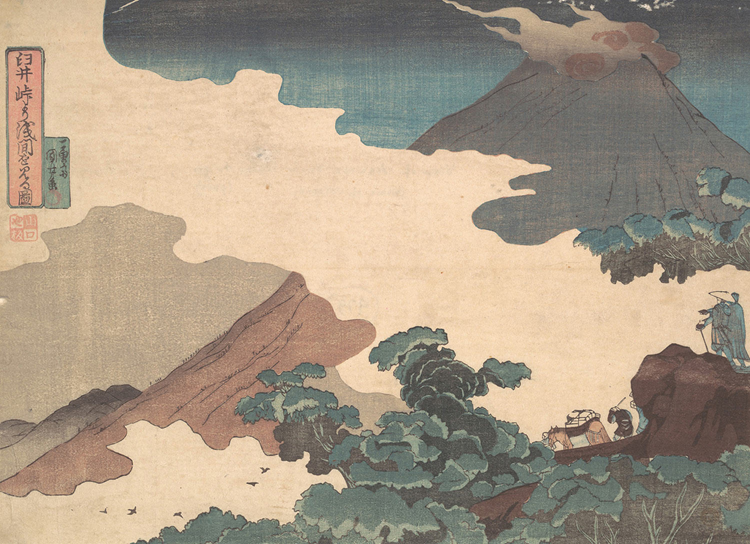

In [ ]:
image_path="GrandeImage.png"
# image_path="PetiteImage.png"

display(Image(image_path))

In [ ]:
import math

def mark_size(h, v):
    # Calcul du nombre de pixels dans l'image
    pixels_nb = h * v

    # Recherche d'un diviseur à partir de 8
    for i in range(8, int(math.sqrt(pixels_nb)) + 1):  # On cherche jusqu'à la racine carrée de pixels_nb
        if pixels_nb % i == 0:
            return i

    # Si aucun diviseur n'est trouvé dans cette plage, on retourne pixels_nb lui-même
    if pixels_nb >= 8:
        return pixels_nb

    raise ValueError("Aucun diviseur trouvé à partir de 8.")

### Treat image


In [98]:
from PIL import Image
import numpy as np

In [99]:
def image_to_grayscale_vector(image_path):
    # Ouvrir l'image
    image = Image.open(image_path)

    # Convertir l'image en niveaux de gris
    grayscale_image = image.convert("L")

    # Convertir l'image en une matrice numpy
    grayscale_matrix = np.array(grayscale_image)

    # Aplatir la matrice en un vecteur
    grayscale_vector = grayscale_matrix.flatten()

    # Obtenir le nombre de lignes et de colonnes de la matrice originale
    rows, columns = grayscale_matrix.shape

    grayscale_list = []
    for i in range(rows*columns):
      grayscale_list.append(grayscale_vector[i])

    return grayscale_vector, grayscale_list, rows, columns


### Reconstruct image

In [91]:
import matplotlib.pyplot as plt

In [92]:
def display_image(flattened_values, image_shape):
    """
    Recrée et affiche une image à partir d'une liste de valeurs aplaties.

    :param flattened_values: Liste des valeurs des pixels (0-255)
    :param image_shape: Tuple (hauteur, largeur) de l'image d'origine
    """
    # Convertir la liste en un tableau numpy et redimensionner
    image_array = np.array(flattened_values, dtype=np.uint8).reshape(image_shape)

    # Afficher l'image
    plt.imshow(image_array, cmap='gray')
    plt.axis('off')
    plt.show()

### Pictures comparison

In [ ]:
from PIL import Image as PILImage
import numpy as np

def pictures_comparison(grayscale_list, reconstructed_list, image_shape):
    """
    Compare l'image en niveaux de gris (extrait de image_to_grayscale_vector) avec l'image reconstruite.

    Paramètres :
    - grayscale_list : Liste des pixels de l'image originale en niveaux de gris.
    - reconstructed_list : Liste reconstruite contenant les valeurs des pixels en niveaux de gris.
    - image_shape : Tuple (hauteur, largeur) pour reshaper les deux listes en images comparables.

    Retour :
    - Différence moyenne des pixels et pourcentage de pixels différents.
    """

    # Convertir les listes en tableaux NumPy et reshaper en images 2D
    image_originale = np.array(grayscale_list, dtype=np.uint8).reshape(image_shape)
    image_reconstruite = np.array(reconstructed_list, dtype=np.uint8).reshape(image_shape)

    # Vérifier si les dimensions correspondent
    if image_originale.shape != image_reconstruite.shape:
        raise ValueError(f"Erreur : Dimensions différentes ! "
                         f"Image originale {image_originale.shape} != Image reconstruite {image_reconstruite.shape}")

    # Vérifier si les deux images sont identiques
    if np.array_equal(image_originale, image_reconstruite):
        print("✅ Les deux images sont identiques !")
    else:
        # Calculer la différence absolue entre les deux images (évite overflow)
        difference = np.abs(image_originale.astype(np.int16) - image_reconstruite.astype(np.int16))

        # Trouver les coordonnées des pixels différents
        y_indices, x_indices = np.where(difference > 0)

        # Erreur moyenne des pixels
        erreur_moyenne = np.mean(difference)

        # Pourcentage de pixels ayant une différence non nulle
        pixels_differents = len(y_indices)
        pourcentage_diff = (pixels_differents / image_originale.size) * 100

        print(f"- Différence moyenne des pixels : {erreur_moyenne:.2f}")
        print(f"- {pourcentage_diff:.2f}% des pixels sont différents.\n")


## Actions

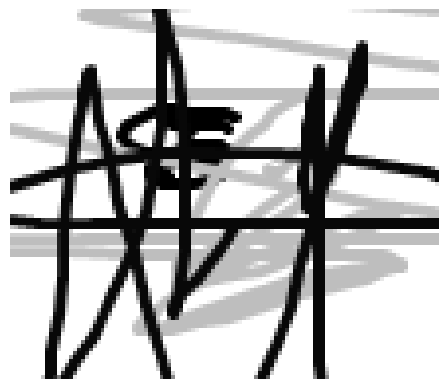

b_premark is : [1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]
b_message is : [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
encrypted_b_message is : [mpz(62123120036103959612095813196016565424341888828021354133806556209209398682636220652376059913381298247863003243004333915060795828745165128733749239766073491865896456349474526185692936391909156298432535372461161854077358218069845322910221627648528652082417976820026387026194615702077317076900641785786887773142), mpz(53562349458271524254967914307971703590466455652396601043030863349725578635984698855835603683925321247471666730532700689095993604540371695106147754128266892285478986489126378604389560131118026590404653798453541696779388227381577558141228164789637474902156312836188520642990796224923123567049480043543268064154), mpz(22203821195141987540901453

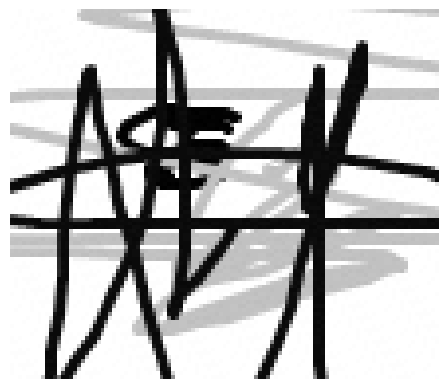

⚠ Les images sont différentes.
   - Différence moyenne des pixels : 0.68
   - 53.45% des pixels sont différents.

🔍 Pixels problématiques (max 10) :
   - Pixel (2, 0) → Original : 255, Reconstruit : 254
   - Pixel (5, 0) → Original : 255, Reconstruit : 254
   - Pixel (13, 0) → Original : 255, Reconstruit : 254
   - Pixel (18, 0) → Original : 227, Reconstruit : 228
   - Pixel (19, 0) → Original : 225, Reconstruit : 226
   - Pixel (20, 0) → Original : 225, Reconstruit : 226
   - Pixel (21, 0) → Original : 225, Reconstruit : 227
   - Pixel (22, 0) → Original : 225, Reconstruit : 227
   - Pixel (23, 0) → Original : 225, Reconstruit : 226
   - Pixel (24, 0) → Original : 225, Reconstruit : 227

 > Image originale (Niveaux de gris) :


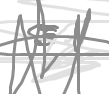


 > Image reconstruite :


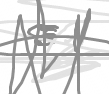

In [ ]:
# Convertit l'image en niveau de gris et en vecteur
grayscale_vector, grayscale_list, rows, columns = image_to_grayscale_vector(image_path)
# Affiche l'image originale en niveau de gris
display_image(grayscale_list,(rows,columns))

# Initialise la demo
demo = ImplementTatoo(h=rows,v=columns,delta=1,value_list=grayscale_list)
demo.print_marks()

# Insère la pré marque générée dans l'image
demo.insert_premark()
print_vector("Insertion de la marque : prémarquage", demo.Iv_pre)

# Chiffre le résultat
demo.pretreatement()
print_vector("Insertion de la marque : prétraitement", demo.Iv_pre_enc)

# Fait une insertion de la marque b message dans le domaine en clair
demo.clair_insertion()
print_vector("Insertion dans le domaine en clair", demo.Iv_pre_enc_ins1)

# Fait une insertion de la marque b message dans le domaine chiffré
demo.ciphered_insertion()
print_vector("Insertion dans le domaine chiffré", demo.Iv_pre_enc_ins1_ins2)

# Vérifie qu'on peut bien extraire la marque b message de chaque bloc chiffré en comparant avec la marque insérée
demo.check_ciphered_extract()

# Déchiffre le vecteur chiffré de l'image
demo.decrypt_Iv()
print_vector("Vecteur déchiffré de l'image", demo.Iv_decrypted)

# Vérifie qu'on peut bien extraire la marque b message de chaque bloc déchiffré en comparant avec la marque insérée
demo.check_clair_extract()

# Affiche l'image déchiffrée contenant la marque
demo.reconstruct_list()
display_image(demo.reconstructed_list,(demo.h,demo.v))

pictures_comparison(grayscale_list, demo.reconstructed_list, image_shape=(demo.h,demo.v))